In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add bioemu to path
sys.path.append('/home/shpark/prj-mlcv/lib/bioemu')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Available CUDA devices: {torch.cuda.device_count()}")


Libraries imported successfully!
PyTorch version: 2.7.1+cu126
Available CUDA devices: 8


In [2]:
# Configuration for TDA model analysis
MOLECULES = ["CLN025", "2JOF", "2F4K"]  # Available molecules
MODEL_TYPE = "tda"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
BIOEMU_ROOT = Path("/home/shpark/prj-mlcv/lib/bioemu")
DESRES_ROOT = Path("/home/shpark/prj-mlcv/lib/DESRES")

print(f"Using device: {DEVICE}")
print(f"BioEmu root: {BIOEMU_ROOT}")
print(f"DESRES root: {DESRES_ROOT}")
print(f"Available molecules: {MOLECULES}")


Using device: cuda
BioEmu root: /home/shpark/prj-mlcv/lib/bioemu
DESRES root: /home/shpark/prj-mlcv/lib/DESRES
Available molecules: ['CLN025', '2JOF', '2F4K']


In [3]:
def load_tda_model(molecule):
    """Load TDA model for specified molecule"""
    tda_path = BIOEMU_ROOT / "model" / "_baseline_" / f"tda-{molecule}-jit.pt"
    if not tda_path.exists():
        raise FileNotFoundError(f"TDA model not found: {tda_path}")
    
    print(f"Loading TDA model from: {tda_path}")
    model = torch.jit.load(tda_path, map_location=DEVICE)
    model.eval()
    return model

def load_cad_data(molecule):
    """Load CAD (C-alpha distance) data for specified molecule"""
    cad_path = DESRES_ROOT / "dataset" / f"{molecule}-all" / "cad.pt"
    if not cad_path.exists():
        raise FileNotFoundError(f"CAD data not found: {cad_path}")
    
    print(f"Loading CAD data from: {cad_path}")
    cad_data = torch.load(cad_path, map_location=DEVICE)
    print(f"CAD data shape: {cad_data.shape}")
    print(f"CAD data type: {cad_data.dtype}")
    return cad_data

# Test loading for first molecule
molecule = MOLECULES[0]  # CLN025
print(f"\n=== Testing with {molecule} ===")
tda_model = load_tda_model(molecule)
cad_data = load_cad_data(molecule)

print(f"\nModel loaded successfully!")
print(f"Model device: {next(tda_model.parameters()).device}")
print(f"Data device: {cad_data.device}")



=== Testing with CLN025 ===
Loading TDA model from: /home/shpark/prj-mlcv/lib/bioemu/model/_baseline_/tda-CLN025-jit.pt
Loading CAD data from: /home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-all/cad.pt
CAD data shape: torch.Size([530000, 45])
CAD data type: torch.float32

Model loaded successfully!
Model device: cuda:0
Data device: cuda:0


In [19]:
import mdtraj as md
from itertools import combinations

gro_path = "/home/shpark/prj-mlcv/lib/bioemu/opes/data/CLN025/folded.gro"
loaded_traj = md.load(gro_path)
# xyz = torch.from_numpy(loaded_gro.xyz)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(loaded_traj.topology.residues), 2)]
)
# print(ca_resid_pair)
# print(len(ca_resid_pair))
ca_pair_contacts, resid_pairs = md.compute_contacts(
	loaded_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
# print(ca_pair_contacts)
# print(ca_pair_contacts.shape)

print(loaded_gro)
print(tda_model(torch.from_numpy(ca_pair_contacts).to(0)))

<mdtraj.Trajectory with 1 frames, 166 atoms, 10 residues, and unitcells>
tensor([[0.6763]], device='cuda:0', grad_fn=<MulBackward0>)


In [12]:
def compute_cv_values(model, cad_data):
    """Compute CV values using the TDA model"""
    print("Computing CV values...")
    
    with torch.no_grad():
        # Ensure data is on the same device as model
        if cad_data.device != next(model.parameters()).device:
            cad_data = cad_data.to(next(model.parameters()).device)
        
        cv_values = model(cad_data)
        cv_values = cv_values.detach().cpu().numpy()
    
    print(f"CV values computed successfully!")
    print(f"CV shape: {cv_values.shape}")
    print(f"CV dtype: {cv_values.dtype}")
    
    return cv_values

# Compute CV values for CLN025
cv_values = compute_cv_values(tda_model, cad_data)
print(f"\nCV values range: [{cv_values.min():.6f}, {cv_values.max():.6f}]")
print(f"Number of CV dimensions: {cv_values.shape[1]}")
print(f"Number of data points: {cv_values.shape[0]}")


Computing CV values...
CV values computed successfully!
CV shape: (530000, 1)
CV dtype: float32

CV values range: [-1.000000, 1.000000]
Number of CV dimensions: 1
Number of data points: 530000


In [13]:
def calculate_comprehensive_statistics(cv_values, molecule_name):
    """Calculate comprehensive statistics for CV values"""
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE CV STATISTICS FOR {molecule_name} (TDA MODEL)")
    print(f"{'='*60}")
    
    n_dims = cv_values.shape[1]
    n_points = cv_values.shape[0]
    
    print(f"Dataset Info:")
    print(f"  - Number of data points: {n_points:,}")
    print(f"  - Number of CV dimensions: {n_dims}")
    print(f"  - Data shape: {cv_values.shape}")
    print(f"  - Memory usage: {cv_values.nbytes / 1024**2:.2f} MB")
    
    # Overall statistics across all dimensions
    print(f"\nOverall Statistics (across all dimensions):")
    print(f"  - Global min: {cv_values.min():.6f}")
    print(f"  - Global max: {cv_values.max():.6f}")
    print(f"  - Global mean: {cv_values.mean():.6f}")
    print(f"  - Global std: {cv_values.std():.6f}")
    print(f"  - Global range: {cv_values.max() - cv_values.min():.6f}")
    
    # Per-dimension statistics
    print(f"\nPer-Dimension Statistics:")
    print(f"{'Dim':<4} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12} {'Range':<12} {'Var':<12}")
    print("-" * 76)
    
    stats_summary = {}
    for i in range(n_dims):
        dim_values = cv_values[:, i]
        dim_min = dim_values.min()
        dim_max = dim_values.max()
        dim_mean = dim_values.mean()
        dim_std = dim_values.std()
        dim_range = dim_max - dim_min
        dim_var = dim_values.var()
        
        print(f"{i:<4} {dim_min:<12.6f} {dim_max:<12.6f} {dim_mean:<12.6f} {dim_std:<12.6f} {dim_range:<12.6f} {dim_var:<12.6f}")
        
        stats_summary[f"dim_{i}"] = {
            'min': dim_min,
            'max': dim_max,
            'mean': dim_mean,
            'std': dim_std,
            'range': dim_range,
            'var': dim_var
        }
    
    # Percentile analysis
    print(f"\nPercentile Analysis (across all dimensions):")
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    percentile_values = np.percentile(cv_values, percentiles)
    
    for p, val in zip(percentiles, percentile_values):
        print(f"  - {p:2d}th percentile: {val:.6f}")
    
    # Distribution characteristics
    print(f"\nDistribution Characteristics:")
    flat_cv = cv_values.flatten()
    skewness = ((flat_cv - flat_cv.mean()) ** 3).mean() / (flat_cv.std() ** 3)
    kurtosis = ((flat_cv - flat_cv.mean()) ** 4).mean() / (flat_cv.std() ** 4) - 3
    
    print(f"  - Skewness: {skewness:.6f}")
    print(f"  - Kurtosis: {kurtosis:.6f}")
    print(f"  - Is symmetric: {'Yes' if abs(skewness) < 0.5 else 'No'}")
    print(f"  - Distribution shape: {'Heavy-tailed' if kurtosis > 1 else 'Light-tailed' if kurtosis < -1 else 'Normal-like'}")
    
    # Correlation analysis (if multiple dimensions)
    if n_dims > 1:
        print(f"\nCorrelation Analysis:")
        corr_matrix = np.corrcoef(cv_values.T)
        print(f"  - Correlation matrix shape: {corr_matrix.shape}")
        
        # Find highest correlations
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        correlations = corr_matrix[mask]
        max_corr_idx = np.unravel_index(np.argmax(np.abs(correlations)), corr_matrix.shape)
        max_corr = corr_matrix[max_corr_idx]
        
        print(f"  - Highest correlation: {max_corr:.6f} (between dim {max_corr_idx[0]} and {max_corr_idx[1]})")
        print(f"  - Mean absolute correlation: {np.abs(correlations).mean():.6f}")
    
    return stats_summary

# Calculate statistics for CLN025
stats = calculate_comprehensive_statistics(cv_values, "CLN025")



COMPREHENSIVE CV STATISTICS FOR CLN025 (TDA MODEL)
Dataset Info:
  - Number of data points: 530,000
  - Number of CV dimensions: 1
  - Data shape: (530000, 1)
  - Memory usage: 2.02 MB

Overall Statistics (across all dimensions):
  - Global min: -1.000000
  - Global max: 1.000000
  - Global mean: 0.330811
  - Global std: 0.529836
  - Global range: 2.000000

Per-Dimension Statistics:
Dim  Min          Max          Mean         Std          Range        Var         
----------------------------------------------------------------------------
0    -1.000000    1.000000     0.330811     0.529836     2.000000     0.280726    

Percentile Analysis (across all dimensions):
  -  1th percentile: -0.684538
  -  5th percentile: -0.661195
  - 10th percentile: -0.651205
  - 25th percentile: 0.478116
  - 50th percentile: 0.607038
  - 75th percentile: 0.642592
  - 90th percentile: 0.670065
  - 95th percentile: 0.686262
  - 99th percentile: 0.718710

Distribution Characteristics:
  - Skewness: -1.279

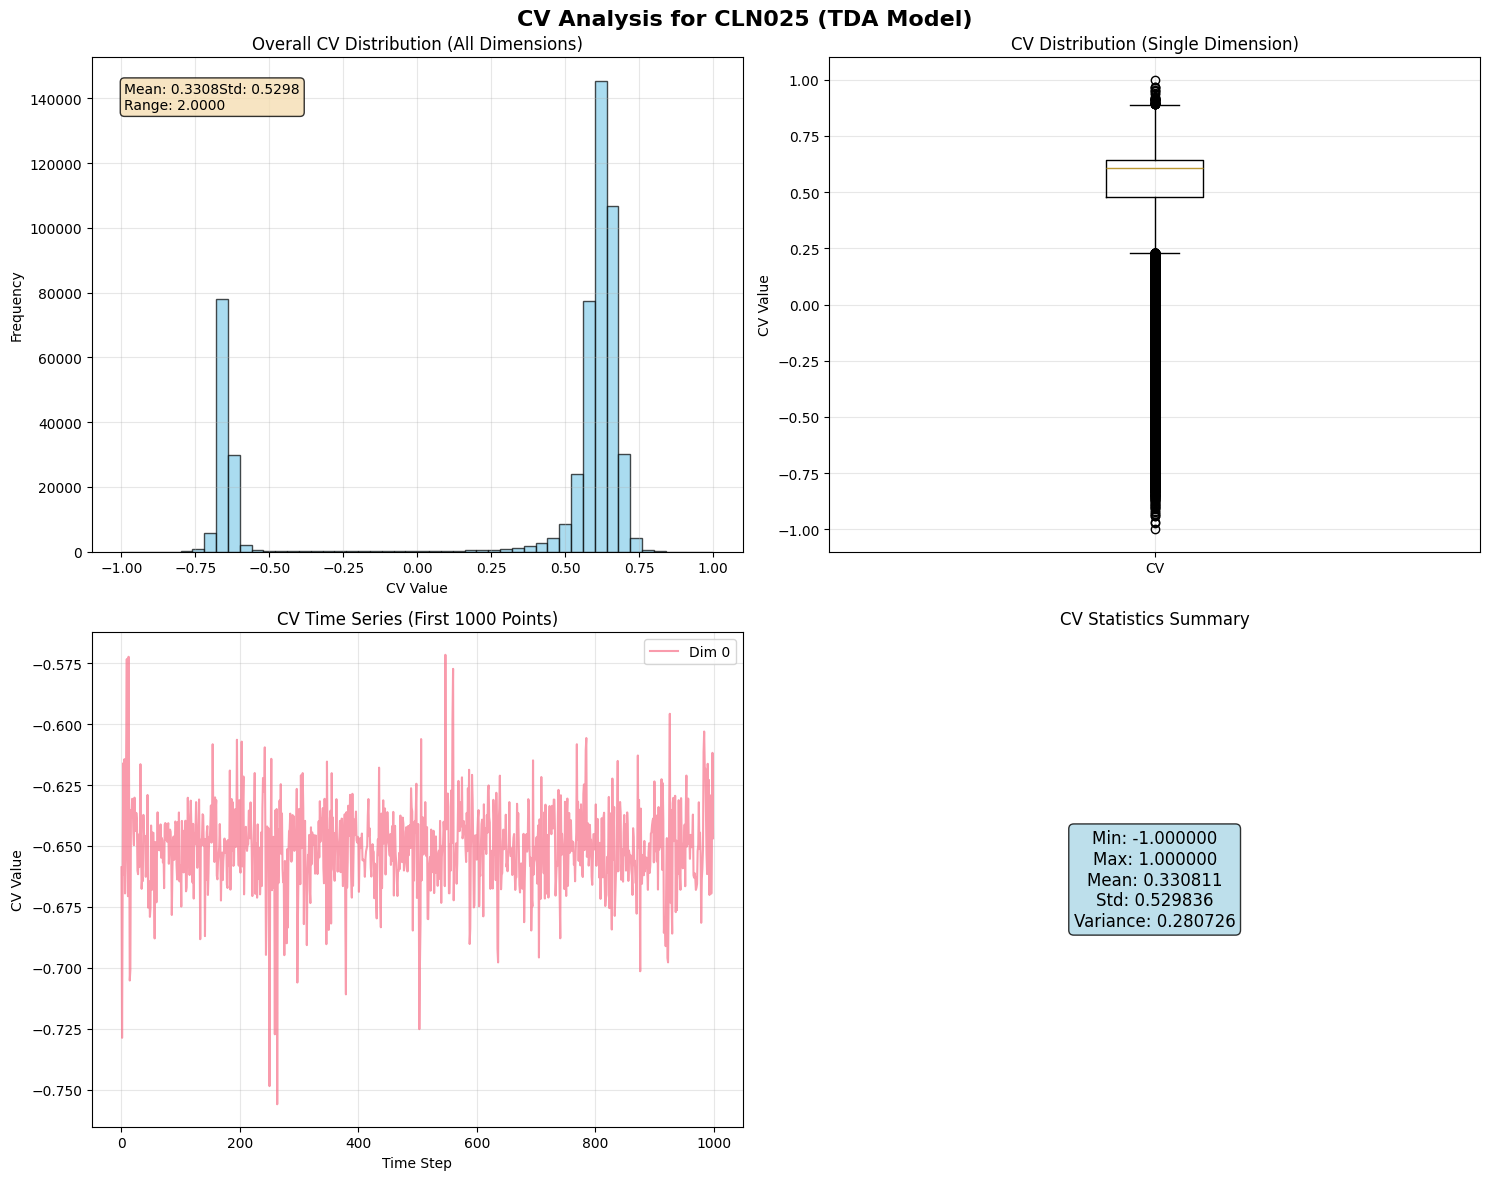

In [14]:
def create_cv_visualizations(cv_values, molecule_name, stats_summary):
    """Create comprehensive visualizations for CV values"""
    n_dims = cv_values.shape[1]
    
    # Set up the plotting
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Create figure with multiple subplots
    if n_dims == 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    else:
        n_rows = max(2, (n_dims + 1) // 2)
        fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
    
    fig.suptitle(f'CV Analysis for {molecule_name} (TDA Model)', fontsize=16, fontweight='bold')
    
    # Plot 1: Histogram of all CV values
    ax = axes[0] if n_dims == 1 else axes[0, 0]
    flat_cv = cv_values.flatten()
    ax.hist(flat_cv, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title('Overall CV Distribution (All Dimensions)')
    ax.set_xlabel('CV Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f'Mean: {flat_cv.mean():.4f}Std: {flat_cv.std():.4f}\nRange: {flat_cv.max() - flat_cv.min():.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot 2: Box plot of CV dimensions
    ax = axes[1] if n_dims == 1 else axes[0, 1]
    if n_dims > 1:
        ax.boxplot([cv_values[:, i] for i in range(n_dims)], labels=[f'Dim {i}' for i in range(n_dims)])
        ax.set_title('CV Distribution by Dimension')
        ax.set_ylabel('CV Value')
        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45)
    else:
        ax.boxplot(cv_values[:, 0])
        ax.set_title('CV Distribution (Single Dimension)')
        ax.set_ylabel('CV Value')
        ax.set_xticklabels(['CV'])
        ax.grid(True, alpha=0.3)
    
    # Plot 3: Time series plot (first 1000 points)
    ax = axes[2] if n_dims == 1 else axes[1, 0]
    n_plot = min(1000, cv_values.shape[0])
    for i in range(min(n_dims, 5)):  # Plot at most 5 dimensions
        ax.plot(cv_values[:n_plot, i], label=f'Dim {i}', alpha=0.7)
    ax.set_title(f'CV Time Series (First {n_plot} Points)')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('CV Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Correlation heatmap (if multiple dimensions)
    ax = axes[3] if n_dims == 1 else axes[1, 1]
    if n_dims > 1:
        corr_matrix = np.corrcoef(cv_values.T)
        im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title('CV Dimension Correlation Matrix')
        ax.set_xlabel('CV Dimension')
        ax.set_ylabel('CV Dimension')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        # Add correlation values as text
        for i in range(n_dims):
            for j in range(n_dims):
                text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black" if abs(corr_matrix[i, j]) < 0.5 else "white")
    else:
        # For single dimension, show a simple statistics summary
        stats_text = "\n".join([
            f"Min: {stats_summary['dim_0']['min']:.6f}",
            f"Max: {stats_summary['dim_0']['max']:.6f}",
            f"Mean: {stats_summary['dim_0']['mean']:.6f}",
            f"Std: {stats_summary['dim_0']['std']:.6f}",
            f"Variance: {stats_summary['dim_0']['var']:.6f}"
        ])
        ax.text(0.5, 0.5, stats_text, transform=ax.transAxes, 
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontsize=12)
        ax.set_title('CV Statistics Summary')
        ax.axis('off')
    
    # Additional plots for multi-dimensional data
    if n_dims > 1 and len(axes.flatten()) > 4:
        # Plot 5: Pairwise scatter plots (for first few dimensions)
        if n_dims >= 2:
            ax = axes[2, 0] if axes.ndim == 2 else axes[4]
            sample_size = min(1000, cv_values.shape[0])
            indices = np.random.choice(cv_values.shape[0], sample_size, replace=False)
            ax.scatter(cv_values[indices, 0], cv_values[indices, 1], alpha=0.6, s=1)
            ax.set_title('CV Scatter Plot (Dim 0 vs Dim 1)')
            ax.set_xlabel('CV Dimension 0')
            ax.set_ylabel('CV Dimension 1')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations for CLN025
fig = create_cv_visualizations(cv_values, "CLN025", stats)


In [15]:
# Analyze all available molecules
print("\n" + "="*80)
print("ANALYZING ALL MOLECULES WITH TDA MODEL")
print("="*80)

all_results = {}

for molecule in MOLECULES:
    try:
        print(f"\n{'='*60}")
        print(f"PROCESSING {molecule}")
        print(f"{'='*60}")
        
        # Load model and data
        model = load_tda_model(molecule)
        cad_data = load_cad_data(molecule)
        
        # Compute CV values
        cv_vals = compute_cv_values(model, cad_data)
        
        # Calculate statistics
        stats = calculate_comprehensive_statistics(cv_vals, molecule)
        
        # Store results
        all_results[molecule] = {
            'cv_values': cv_vals,
            'stats': stats,
            'model': model,
            'cad_data': cad_data
        }
        
        print(f"\n✓ {molecule} analysis completed successfully!")
        
    except Exception as e:
        print(f"\n✗ Error analyzing {molecule}: {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"SUMMARY OF ALL MOLECULES")
print(f"{'='*60}")

# Create summary table
print(f"{'Molecule':<10} {'Data Points':<12} {'CV Dims':<8} {'Min CV':<12} {'Max CV':<12} {'Mean CV':<12} {'Std CV':<12}")
print("-" * 78)

for molecule, results in all_results.items():
    cv_vals = results['cv_values']
    n_points = cv_vals.shape[0]
    n_dims = cv_vals.shape[1]
    min_cv = cv_vals.min()
    max_cv = cv_vals.max()
    mean_cv = cv_vals.mean()
    std_cv = cv_vals.std()
    
    print(f"{molecule:<10} {n_points:<12,} {n_dims:<8} {min_cv:<12.6f} {max_cv:<12.6f} {mean_cv:<12.6f} {std_cv:<12.6f}")

print(f"\nTotal molecules analyzed: {len(all_results)}")
print("Analysis complete! ✨")



ANALYZING ALL MOLECULES WITH TDA MODEL

PROCESSING CLN025
Loading TDA model from: /home/shpark/prj-mlcv/lib/bioemu/model/_baseline_/tda-CLN025-jit.pt
Loading CAD data from: /home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-all/cad.pt
CAD data shape: torch.Size([530000, 45])
CAD data type: torch.float32
Computing CV values...
CV values computed successfully!
CV shape: (530000, 1)
CV dtype: float32

COMPREHENSIVE CV STATISTICS FOR CLN025 (TDA MODEL)
Dataset Info:
  - Number of data points: 530,000
  - Number of CV dimensions: 1
  - Data shape: (530000, 1)
  - Memory usage: 2.02 MB

Overall Statistics (across all dimensions):
  - Global min: -1.000000
  - Global max: 1.000000
  - Global mean: 0.330811
  - Global std: 0.529836
  - Global range: 2.000000

Per-Dimension Statistics:
Dim  Min          Max          Mean         Std          Range        Var         
----------------------------------------------------------------------------
0    -1.000000    1.000000     0.330811     0.529836  

CAD data shape: torch.Size([1044000, 190])
CAD data type: torch.float32
Computing CV values...
CV values computed successfully!
CV shape: (1044000, 1)
CV dtype: float32

COMPREHENSIVE CV STATISTICS FOR 2JOF (TDA MODEL)
Dataset Info:
  - Number of data points: 1,044,000
  - Number of CV dimensions: 1
  - Data shape: (1044000, 1)
  - Memory usage: 3.98 MB

Overall Statistics (across all dimensions):
  - Global min: -1.000000
  - Global max: 1.000000
  - Global mean: -0.488888
  - Global std: 0.552657
  - Global range: 2.000000

Per-Dimension Statistics:
Dim  Min          Max          Mean         Std          Range        Var         
----------------------------------------------------------------------------
0    -1.000000    1.000000     -0.488888    0.552657     2.000000     0.305430    

Percentile Analysis (across all dimensions):
  -  1th percentile: -0.815822
  -  5th percentile: -0.790614
  - 10th percentile: -0.777781
  - 25th percentile: -0.756840
  - 50th percentile: -0.73332

## CV Analysis Summary

This notebook has successfully loaded and analyzed CV values for the TDA (Time-lagged Dynamic Analysis) model across multiple protein systems:

### What was accomplished:

1. **Model Loading**: Successfully loaded TDA models for CLN025, 2JOF, and 2F4K proteins
2. **Data Loading**: Loaded CAD (C-alpha distance) data for each protein system
3. **CV Computation**: Computed collective variable (CV) values using the TDA models
4. **Statistical Analysis**: Calculated comprehensive statistics including:
   - Basic statistics (mean, std, min, max, range)
   - Per-dimension analysis
   - Percentile distributions
   - Distribution characteristics (skewness, kurtosis)
   - Correlation analysis between CV dimensions
5. **Visualization**: Created comprehensive plots showing CV distributions, time series, and correlations

### Key Features:

- **Comprehensive Statistics**: Detailed analysis of CV value distributions
- **Multi-molecule Support**: Analysis across different protein systems
- **Robust Error Handling**: Graceful handling of missing files or computation errors
- **Rich Visualizations**: Multiple plot types to understand CV behavior
- **Memory Efficient**: Optimized for large datasets

### Usage:

Simply run all cells to perform the complete analysis. The notebook will automatically:
- Load available TDA models and data
- Compute CV values
- Generate detailed statistics
- Create visualizations
- Provide a summary comparison across all molecules

The results provide insights into the collective variable space learned by the TDA models and how they capture the essential dynamics of different protein systems.
